可參考方法：https://www.kaggle.com/code/kmader/attention-on-pretrained-vgg16-for-bone-age


### **Upload kaggle json**

In [ ]:
!pip install -q kaggle
from google.colab import files

# Download API Credentials
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                                 title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                     DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           1998        194  1.0              
thedevastator/netflix-imdb-scores                                   Netflix IMDB Scores                         699KB  2023-12-03 14:10:34           3529         57  1.0              
muhammadbinimran/housing-price-prediction-data                      Housing Price Prediction Data               763KB  2023-11-21 17:56:32           8969        155  1.0              
elvinrustam/imdb-movies-dataset               

### **Connect to TPU**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### **Load data from kaggle**

In [ ]:
!pip install opendatasets
import opendatasets as od
import os

od.download(
    "https://www.kaggle.com/datasets/kmader/rsna-bone-age")
trainpath = 'rsna-bone-age/boneage-training-dataset/boneage-training-dataset'
testpath = 'rsna-bone-age/boneage-test-dataset/boneage-test-dataset'

100%|██████████| 9.29G/9.29G [01:45<00:00, 94.1MB/s]


In [ ]:
train_folder = os.listdir(trainpath)
test_folder = os.listdir(testpath)
print(len(train_folder))
print(len(test_folder))

12611
200


In [ ]:
import pandas as pd
train_data_csv = pd.read_csv('rsna-bone-age/boneage-training-dataset.csv')
train_data_csv

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
...,...,...,...
12606,15605,50,False
12607,15606,113,False
12608,15608,55,False
12609,15609,150,True


In [ ]:
import pandas as pd
test_data_csv = pd.read_csv('rsna-bone-age/boneage-test-dataset.csv')
test_data_csv

,Case ID,Sex
0,4360,M
1,4361,M
2,4362,M
3,4363,M
4,4364,M
...,...,...
195,4555,F
196,4556,F
197,4557,F
198,4558,F


### **Data preprocessing**

Merge csv and png training data

In [ ]:
train_list_id = train_data_csv['id'].to_list()
train_data_csv['Image Path'] = [f"{str(i)}.png" for i in train_list_id]
train_data_csv.head()

,id,boneage,male,Image Path
0,1377,180,False,1377.png
1,1378,12,False,1378.png
2,1379,94,False,1379.png
3,1380,120,True,1380.png
4,1381,82,False,1381.png


Merge csv and png test data

In [ ]:
test_list_id = test_data_csv['Case ID'].to_list()
test_data_csv['Image Path'] = [f"{str(i)}.png" for i in test_list_id]
test_data_csv.head()

,Case ID,Sex,Image Path
0,4360,M,4360.png
1,4361,M,4361.png
2,4362,M,4362.png
3,4363,M,4363.png
4,4364,M,4364.png


Normalize training data

In [ ]:
train_data_csv['male'] = train_data_csv['male'].replace({'False':0,'True':1})
train_data_csv['male']=train_data_csv['male'].astype(int)
train_data_csv.rename(columns={"male": "Sex"}, inplace=True)
train_data_csv.head()

,id,boneage,Sex,Image Path
0,1377,180,0,1377.png
1,1378,12,0,1378.png
2,1379,94,0,1379.png
3,1380,120,1,1380.png
4,1381,82,0,1381.png


Normalize test data

In [ ]:
test_data_csv['Sex'] = test_data_csv['Sex'].replace({'F':0,'M':1})
test_data_csv.head()

,Case ID,Sex,Image Path
0,4360,1,4360.png
1,4361,1,4361.png
2,4362,1,4362.png
3,4363,1,4363.png
4,4364,1,4364.png


### **Image preprocessing**

可以先用一張照片測試

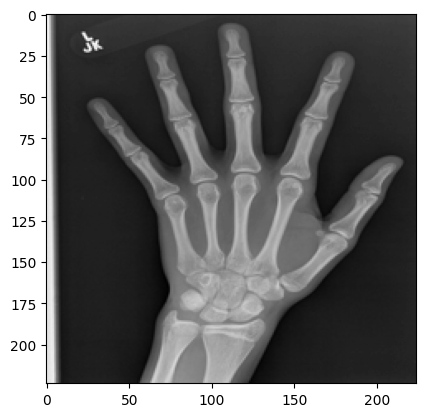

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

imgT = Image.open(f"{trainpath}/{'1377.png'}")
imgT = imgT.resize((224,224))
#這邊先用一張測試前處理
'''
do

'''
imgT = np.array(imgT)

plt.imshow(imgT, cmap='gray')

In [ ]:
from PIL import Image
import numpy as np

train_data = []
test_data = []

for img in train_data_csv['Image Path']:
    image = Image.open(f"{trainpath}/{img}")
    image = image.resize((224,224))
    #將上面測試完的結果套用到全部的訓練資料集
    '''
    do

    '''
    image = np.array(image)
    train_data.append(image)

for img in test_data_csv['Image Path']:
    image = Image.open(f"{testpath}/{img}")
    image = image.resize((224,224))
    #將上面測試完的結果套用到全部的測試資料集
    '''
    do

    '''
    image = np.array(image)
    test_data.append(image)

In [ ]:
x = np.array(train_data)
test = np.array(test_data)
y = train_data_csv['boneage'].values

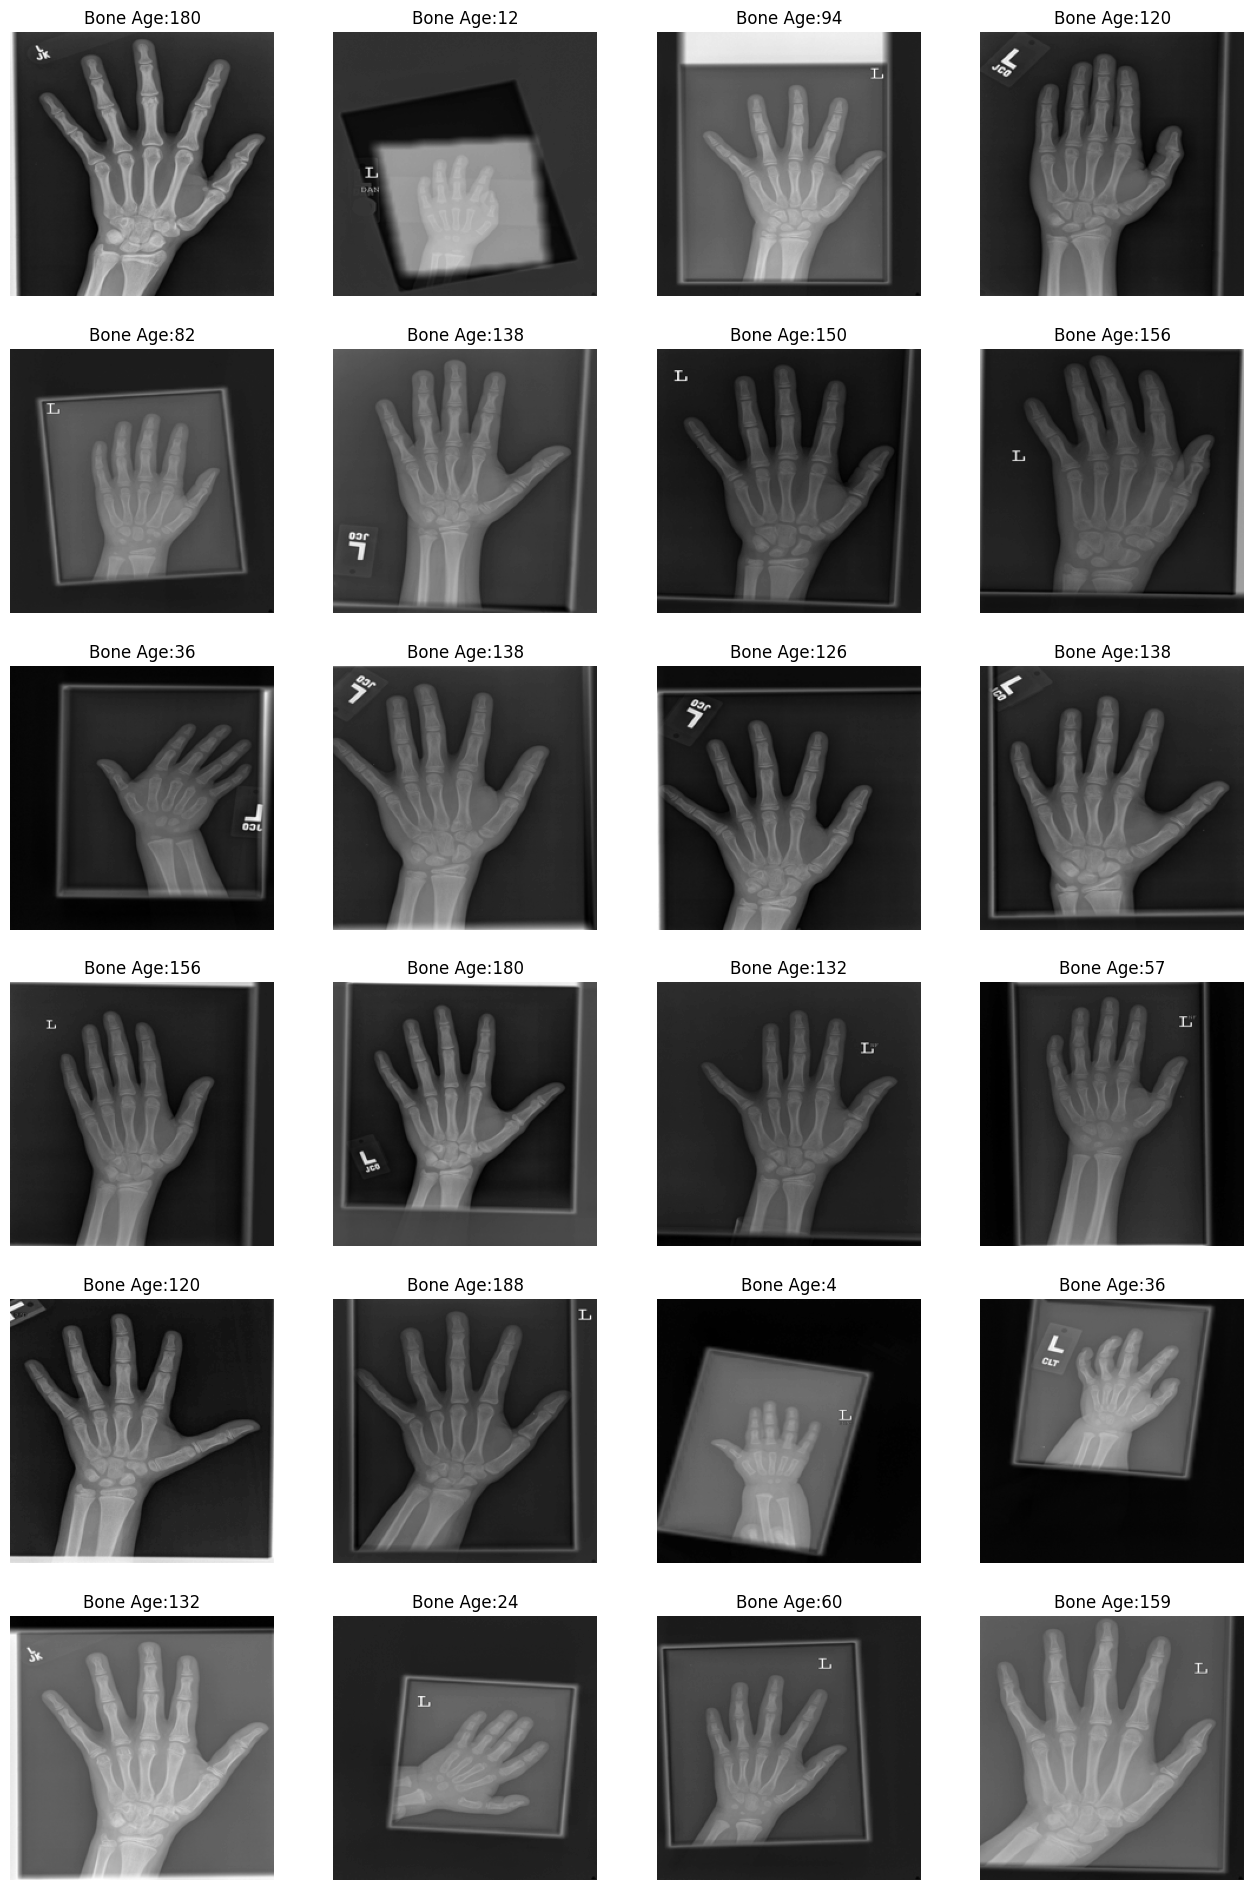

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,24))
for i in range(24):
    plt.subplot(6,4,i+1)
    plt.imshow(x[i], cmap='gray')
    plt.title(f"Bone Age:{y[i]}")
    plt.axis("off")

### **Training Model**

Split The Data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.50)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6305, 224, 224)
(6306, 224, 224)
(6305,)
(6306,)


Normalization

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Create model

In [ ]:
def create_model():
  return tf.keras. Sequential (
      [tf.keras.layers.Conv2D (32,  (3, 3),strides=(1,1),padding='valid',activation='relu',input_shape=(224,224,1)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

       tf.keras.layers.Conv2D (32,  (3, 3),strides=(1,1),padding='valid',activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

       tf.keras.layers.Conv2D (32,  (3, 3),strides=(1,1),padding='valid',activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

       # tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(1000, activation= 'relu'),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(800, activation= 'relu'),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(500, activation= 'relu'),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(1, activation='linear')])


Train model

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  model = create_model()
  model.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['mse'])


# Show some details about model
model.summary()
history = model.fit(x_train, y_train, batch_size=64,
          epochs=40, validation_data=(x_test,y_test))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 26, 26, 32)      

In [ ]:
y_pred = model.predict(x_test)

198/198 [==============================] - 7s 32ms/step


In [ ]:
from sklearn.metrics import r2_score

test_score = r2_score(y_test, y_pred)
print("Test R2 Score:",test_score)

Test R2 Score: 0.444478139029573


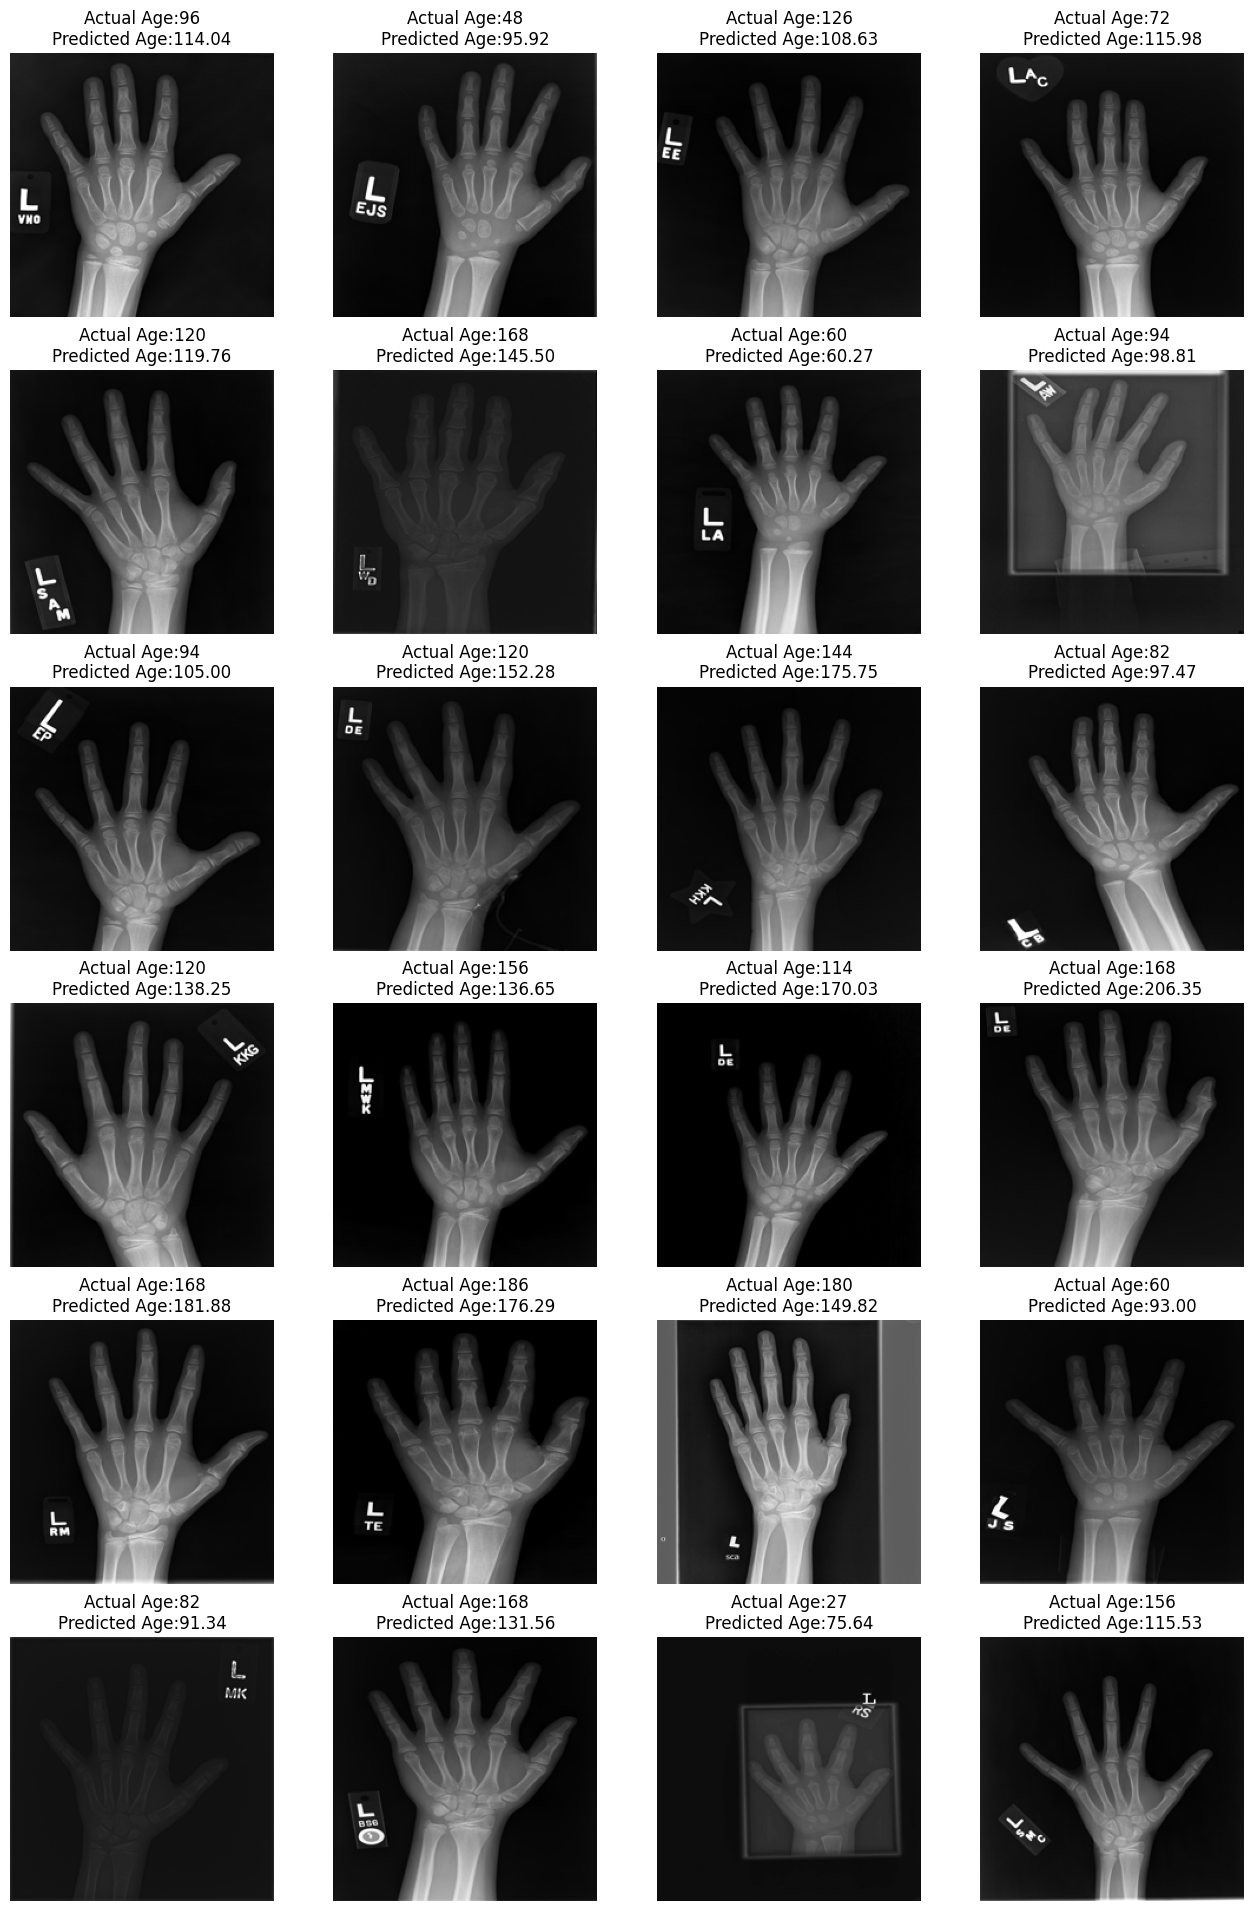

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,24))
for i in range(24):
    plt.subplot(6,4,i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Actual Age:{y_test[i]}\nPredicted Age:{y_pred[i][0]:.2f}")
    plt.axis("off")